In [130]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch import optim
from functorch import  make_functional
from torch.func import vmap, grad, jvp, vjp
import torch.nn.functional as F
from torchvision.datasets import MNIST
import torchvision.transforms as T
from torch.utils.data import Subset, DataLoader
from lanczos.lanczos_hm import HighMemoryLanczos
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### workflow:
1. train NN on mps
2. conduct the GGN-vector product for tensors on mps
3. define the operator for cpu numpy: be careful about the dtype! (currently using `float32` for pytorch part)
4. apply Lanczos

In [76]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"device: {device}")

device: mps


### Spectral Properties

In [125]:
# 1. Load MNIST
transform = T.Compose([T.ToTensor(), T.Lambda(lambda x: x.view(-1))])
mnist = MNIST(root="./", train=True, download=True, transform=transform)
loader = DataLoader(mnist, batch_size=2000, shuffle=True)
X_batch, Y_batch = next(iter(loader))
X_batch = X_batch.float().to(device)
Y_batch = Y_batch.long().to(device)

# 2. Small model
class SmallNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
        )
    def forward(self, x):
        return self.net(x)
# device = torch.device("cpu")
model = SmallNet().to(device)

In [126]:
print(model)

SmallNet(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [127]:
# 3. Train 
def train(model, X, Y, epochs=300):
    opt = torch.optim.Adam(model.parameters(), lr=1e-2)
    for epoch in range(epochs):
        opt.zero_grad()
        out = model(X)
        loss = F.cross_entropy(out, Y)
        loss.backward()
        opt.step()
        if epoch % 50 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
        if epoch + 1 >= epochs:
            print(f'Epoch {epoch}, Final Loss: {loss.item()}')

In [97]:
def make_ggn_matvec_operator(model, X, Y, loss_type="cross_entropy"):
    fmodel, params = make_functional(model)
    params_flat = torch.cat([p.view(-1) for p in params]).to(X.device)

    X = X.to(X.device)
    Y = Y.to(Y.device)

    def compute_outputs(p, x):
        # Unflatten parameters
        params_unflat = []
        idx = 0
        for param in params:
            numel = param.numel()
            params_unflat.append(p[idx:idx+numel].view_as(param).to(x.device))
            idx += numel
        return fmodel(tuple(params_unflat), x.unsqueeze(0)).squeeze(0)

    def make_loss_fn(y):
        if loss_type == "cross_entropy":
            return lambda o: F.cross_entropy(o.unsqueeze(0), y.unsqueeze(0), reduction='mean')
        elif loss_type == "mse":
            return lambda o: F.mse_loss(o.unsqueeze(0), y.unsqueeze(0).float(), reduction='mean')
        elif loss_type == "binary_cross_entropy":
            return lambda o: F.binary_cross_entropy_with_logits(o.unsqueeze(0), y.unsqueeze(0).float())
        else:
            raise ValueError(f"Unsupported loss_type: {loss_type}")

    def ggn_matvec(v_flat):
        v_flat = v_flat.to(X.device)

        def per_sample_ggn(x, y):
            loss_fn = make_loss_fn(y)

            # 1. Compute Jv
            outputs, jvp_out = jvp(
                lambda p: compute_outputs(p, x),
                (params_flat,),
                (v_flat,)
            )

            # 2. Compute H Jv
            grad_fn = grad(loss_fn)
            H_jvp = jvp(grad_fn, (outputs,), (jvp_out,))[1]

            # 3. Compute J^T (H Jv)
            _, vjp_fn = vjp(lambda p: compute_outputs(p, x), params_flat)
            return vjp_fn(H_jvp)[0]

        return vmap(per_sample_ggn)(X, Y).sum(0)

    return ggn_matvec 

In [121]:
# One-time setup
ggn_mv_torch = make_ggn_matvec_operator(model, X_batch, Y_batch, loss_type="cross_entropy")

# Step 2: Wrap it in a NumPy interface
def ggn_mv_numpy(v_np):
    v_torch = torch.from_numpy(v_np).float()
    Gv = ggn_mv_torch(v_torch)
    return Gv.detach().cpu().numpy()
params_flat = torch.cat([p.view(-1) for p in model.parameters()])
num_params = len(params_flat)
# Apply repeatedly
v = torch.rand(num_params)
Gv = ggn_mv_torch(v)

print("Gv:", Gv.shape)

Gv: torch.Size([25818])


/var/folders/f7/mv77nwv55x56_sblzsnk3n2r0000gn/T/ipykernel_90805/1733383812.py:2: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fmodel, params = make_functional(model)


In [ ]:
EPOCHS_BASED_ON_SIZE = {10: 300, 100: 100, 1000: 50}
sample_sizes = [10, 100, 1000]
lanczos_steps = [10, 100, 1000]
results = {}
for n_samples in [10, 100, 1000]:
    # 1. Subsample
    X_sub = X_batch[:n_samples]
    Y_sub = Y_batch[:n_samples]

    # 2. New model
    model = SmallNet().to(device)
    train(model, X_sub, Y_sub, epochs=EPOCHS_BASED_ON_SIZE[n_samples])

    # 3. Build matvec
    ggn_mv_torch = make_ggn_matvec_operator(model, X_sub, Y_sub )

    def ggn_mv_numpy(v_np):
        return ggn_mv_torch(torch.from_numpy(v_np).float()).detach().cpu().numpy()

    # 4. Run Lanczos for different steps
    num_params = sum(p.numel() for p in model.parameters())

    for steps in lanczos_steps:
        print(f"Running: samples={n_samples}, steps={steps}")
        solver = HighMemoryLanczos(G_matvec=ggn_mv_numpy, p=num_params)
        solver.run(num_steps=steps)
        _, evals = solver.get_top_eigenpairs()
        key = (n_samples, steps)
        results[key] = evals

Epoch 0, Loss: 2.3060648441314697
Epoch 50, Loss: 2.0324659999459982e-05
Epoch 100, Loss: 4.95908079756191e-06
Epoch 150, Loss: 2.7656474230752792e-06
Epoch 200, Loss: 1.8835029322872288e-06
Epoch 250, Loss: 1.4066674793866696e-06
Epoch 299, Final Loss: 1.0848032161447918e-06
Running: samples=10, steps=10
Running: samples=10, steps=100


/var/folders/f7/mv77nwv55x56_sblzsnk3n2r0000gn/T/ipykernel_90805/1733383812.py:2: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fmodel, params = make_functional(model)


Running: samples=10, steps=1000
Epoch 0, Loss: 2.3156845569610596
Epoch 50, Loss: 6.724939157720655e-05
Epoch 99, Final Loss: 3.3393156627425924e-05
Running: samples=100, steps=10
Running: samples=100, steps=100
Running: samples=100, steps=1000
Epoch 0, Loss: 2.315645217895508
Epoch 49, Final Loss: 0.012462264858186245
Running: samples=1000, steps=10
Running: samples=1000, steps=100
Running: samples=1000, steps=1000


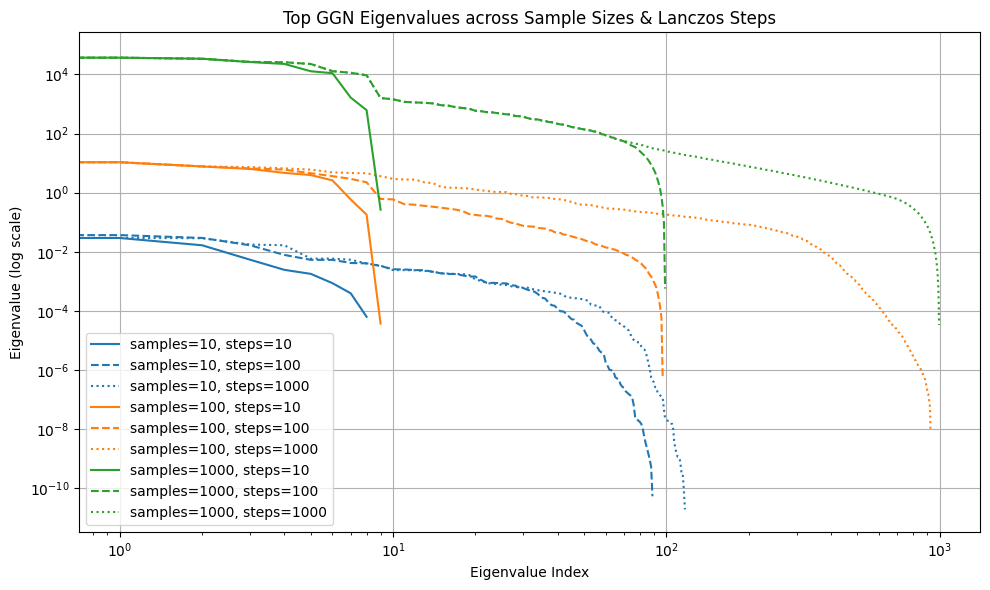

In [123]:
import matplotlib.pyplot as plt
sample_colors = {
    10: "tab:blue",
    100: "tab:orange",
    1000: "tab:green"
}
step_styles = {
    10: "-",
    100: "--",
    1000: ":"
}

plt.figure(figsize=(10, 6))

for (samples, steps), evals in results.items():
    clean_evals = evals[evals > 0]
    color = sample_colors[samples]
    linestyle = step_styles[steps]
    label = f"samples={samples}, steps={steps}"
    plt.plot(clean_evals, color=color, linestyle=linestyle, label=label)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue (log scale)")
plt.title("Top GGN Eigenvalues across Sample Sizes & Lanczos Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Post-hoc orthogonalization
- run 50 steps, top 45 (90%) eigenpairs
- top-5 principle components

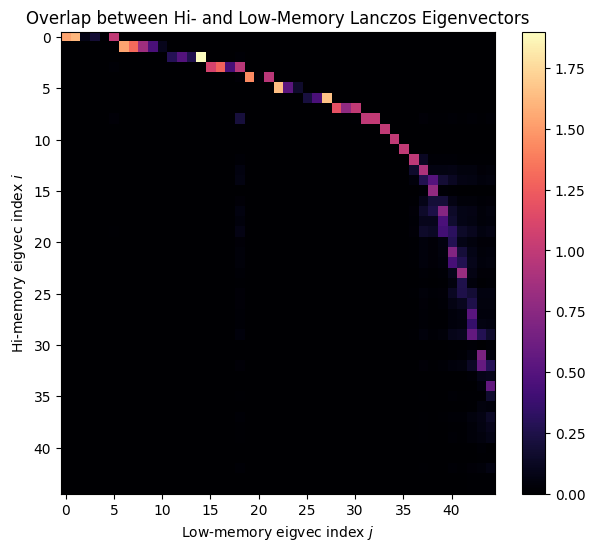

In [166]:
n = num_params
num_steps = 50
top_k = int(num_steps*0.9)

# hi-memory 
solver_hm = HighMemoryLanczos(G_matvec=ggn_mv_numpy, p=n)
solver_hm.run(num_steps, ortho=True)

# low-memory 
solver_lm = HighMemoryLanczos(G_matvec=ggn_mv_numpy, p=n)
solver_lm.run(num_steps, ortho=False)

vecs_hm, vals_hm = solver_hm.get_top_eigenpairs(k=top_k, evec=True)
vecs_lm, vals_lm = solver_lm.get_top_eigenpairs(k=top_k, evec=True)

# vecs_hm = normalize_columns(vecs_hm)
# vecs_lm = normalize_columns(vecs_lm)

overlap = np.abs(vecs_hm.T @ vecs_lm)

# Plot
plt.figure(figsize=(7, 6))
plt.imshow(overlap, cmap="magma", interpolation="nearest", aspect="auto")
plt.colorbar()
plt.title("Overlap between Hi- and Low-Memory Lanczos Eigenvectors")
plt.xlabel("Low-memory eigvec index $j$")
plt.ylabel("Hi-memory eigvec index $i$")
plt.show()

In [167]:
vecs_hm.shape

(25818, 45)

In [168]:
from numpy.linalg import norm, svd
# L * Gamma_L and H * Gamma_H
weighted_lm = vecs_lm[:, :top_k] * vals_lm[:top_k]  # broadcast multiply
weighted_hm = vecs_hm[:, :top_k] * vals_hm[:top_k]

# SVD 
U_lm, a, _ = svd(weighted_lm, full_matrices=False)
U_hm, b, _ = svd(weighted_hm, full_matrices=False)

In [ ]:
from scipy.linalg import subspace_angles
# projection matrices from top-5 principal components
Q_lm = U_lm[:, :5]
Q_hm = U_hm[:, :5]
# Q_lm, Q_hm are (p x 5), orthonormal basis
angles = subspace_angles(Q_lm, Q_hm)  # returns array of 5 principal angles in radians

# operator norm difference ≈ sin(max angle)
proj_diff_fast = np.sin(angles[0])


In [174]:
proj_diff_fast

0.06389635659259775

In [ ]:
# mat-vec multiplication
def proj(Q, x):
    return Q @ (Q.T @ x)

# A @ x = (Pi_lm - Pi_hm) @ x
def proj_diff_mv(x):
    return proj(Q_lm, x) - proj(Q_hm, x)

# Power method to approximate ||Pi_lm - Pi_hm||_2
def power_method(mv_func, dim, n_iter=100, tol=1e-6):
    x = np.random.randn(dim)
    x = x / np.linalg.norm(x)
    prev_lambda = 0.0

    for i in range(n_iter):
        y = mv_func(x)
        lambda_ = np.linalg.norm(y)
        x = y / lambda_
        if abs(lambda_ - prev_lambda) < tol:
            break
        prev_lambda = lambda_

    return lambda_

proj_norm = power_method(proj_diff_mv, dim=num_params)
proj_norm

0.06389635656109784

In [128]:
# Example model and data
model = nn.Sequential(nn.Linear(2, 3), nn.Linear(3, 2))
X = torch.randn(5, 2)  # Batch size 5
Y = torch.tensor([0, 1, 0, 1, 0])

# Flatten parameters and create test vector
fmodel, params = make_functional(model)
params_flat = torch.cat([p.view(-1) for p in params])
v_flat = torch.randn_like(params_flat)

# Compute GGN-vector product
ggn_v = ggn_vector_product(model, X, Y, v_flat)
print(ggn_v.shape)  # Should match params_flat.shape (e.g., torch.Size([17]))

torch.Size([17])


/var/folders/f7/mv77nwv55x56_sblzsnk3n2r0000gn/T/ipykernel_55627/3307843980.py:7: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fmodel, params = make_functional(model)
/var/folders/f7/mv77nwv55x56_sblzsnk3n2r0000gn/T/ipykernel_55627/2906257993.py:9: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.mig

In [129]:
ggn_v

tensor([ 9.6254e-04, -1.9381e-03, -7.7608e-02,  1.5626e-01,  2.6967e-02,
        -5.4297e-02,  1.8810e-04, -1.5164e-02,  5.2692e-03, -3.6658e-01,
         1.7093e-01,  7.7738e-02,  3.6658e-01, -1.7093e-01, -7.7738e-02,
         6.9455e-02, -6.9455e-02], grad_fn=<SumBackward1>)

In [124]:
def ggn_vector_product(model, x, y, v_flat):
    model.eval()
    
    # Convert model to functional form and flatten parameters
    fmodel, params = make_functional(model)
    params_flat = torch.cat([p.view(-1) for p in params])
    
    # Function to unflatten parameters and compute outputs
    def f(p_flat):
        params_unflat = []
        current_idx = 0
        for param in params:
            numel = param.numel()
            params_unflat.append(p_flat[current_idx : current_idx + numel].view_as(param))
            current_idx += numel
        return fmodel(tuple(params_unflat), x)
    
    # Forward pass to get outputs and loss
    outputs = f(params_flat)
    loss = nn.CrossEntropyLoss()(outputs, y)
    
    # Step 1: Compute Jθ · v (Jacobian-vector product)
    jvp_result = jvp(f, (params_flat,), (v_flat,))[1]  # Shape: [batch_size, output_dim]
    # print(jvp_result)
    
    # Step 2: Compute H · (Jθ · v) (Hessian-vector product)
    grad_output = torch.autograd.grad(loss, outputs, create_graph=True)[0]  # ∇_f ℓ
    H_jvp = torch.autograd.grad(
        grad_output, outputs, grad_outputs=jvp_result, retain_graph=True
    )[0]  # H · Jθ · v
    # print("H_jvp", H_jvp.shape)
    
    # Step 3: Compute Jθᵀ · (H · Jθ · v) (Vector-Jacobian product)
    _, vjp_result = vjp(f, params_flat, H_jvp)
    # print("vjp_result",vjp_result)
    return vjp_result

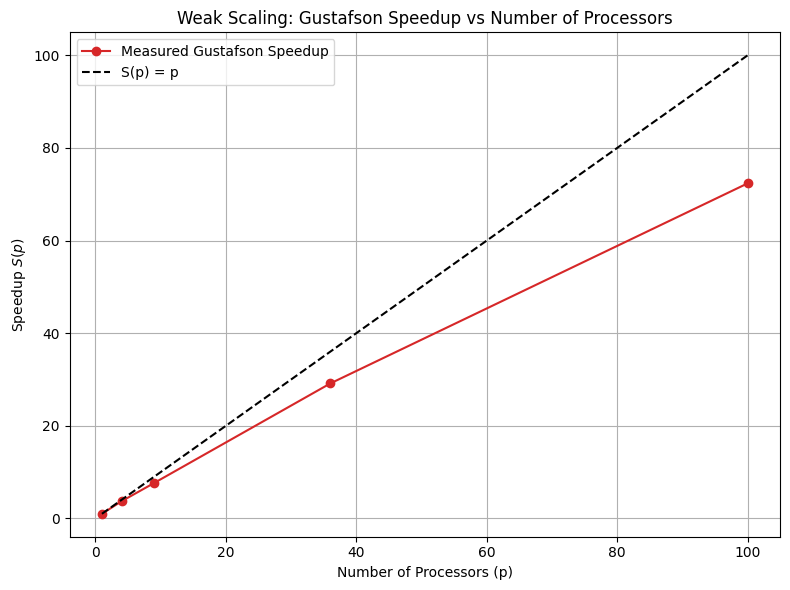

In [18]:
# Re-import required libraries after code state reset
import matplotlib.pyplot as plt

procs = [1, 4, 9, 36, 100]
total_time = [0.1956318, 0.4071899, 0.8243688, 6.488156, 28.51904]
parallel_time = [0.1871097, 0.3669832, 0.6852797, 5.216060, 20.55354]


# Calculate alpha and Gustafson speedup
alpha = [p / t for p, t in zip(parallel_time, total_time)]
speedup = [1 + (p - 1) * a for p, a in zip(procs, alpha)]

# Ideal speedup = p
ideal_speedup = procs

# Plotting speedup vs p with ideal diagonal
plt.figure(figsize=(8, 6))
plt.plot(procs, speedup, 'o-', label='Measured Gustafson Speedup', color='tab:red')
plt.plot(procs, ideal_speedup, 'k--', label='S(p) = p', linewidth=1.5)

plt.title('Weak Scaling: Gustafson Speedup vs Number of Processors')
plt.xlabel('Number of Processors (p)')
plt.ylabel('Speedup $S(p)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


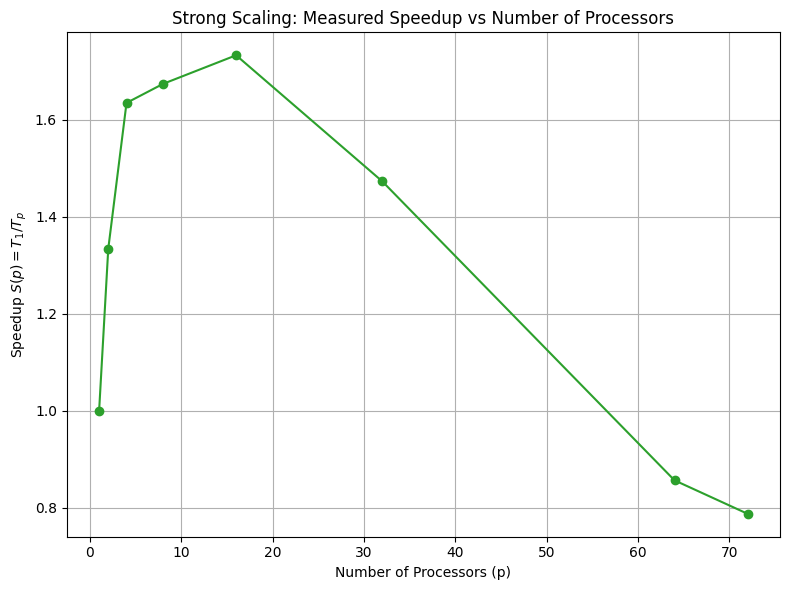

In [10]:

# Strong scaling data parsed from the uploaded file
strong_procs = [1, 2, 4, 8, 16, 32, 64, 72]
strong_total_time = [283.0789, 212.2504, 173.1685, 169.1088, 163.3502, 192.1888, 330.6318, 359.6240]

# Compute strong scaling speedup relative to 1 processor
T1 = strong_total_time[0]
strong_speedup = [T1 / t for t in strong_total_time]
ideal_speedup = strong_procs  # ideal linear speedup

plt.figure(figsize=(8, 6))
plt.plot(strong_procs, strong_speedup, 'o-', label='Measured Speedup', color='tab:green')

plt.title('Strong Scaling: Measured Speedup vs Number of Processors')
plt.xlabel('Number of Processors (p)')
plt.ylabel('Speedup $S(p) = T_1 / T_p$')
plt.grid(True)
plt.tight_layout()
plt.show()

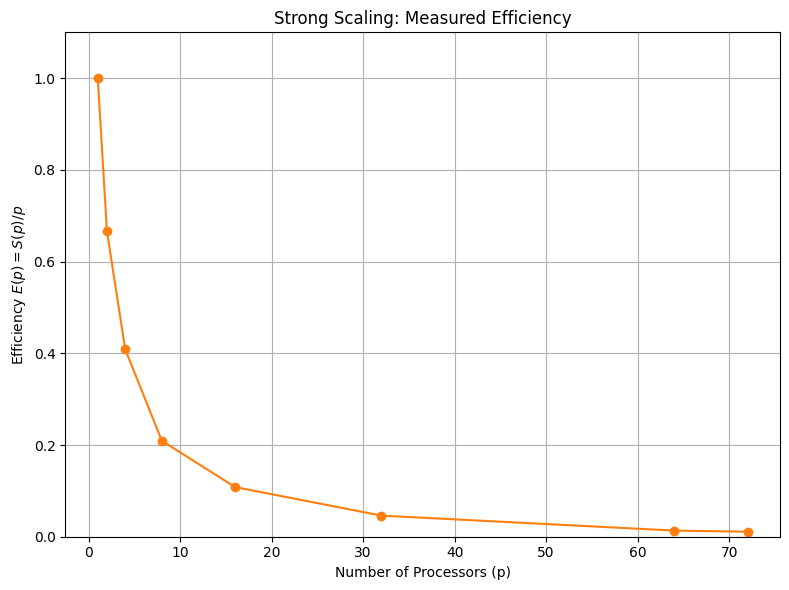

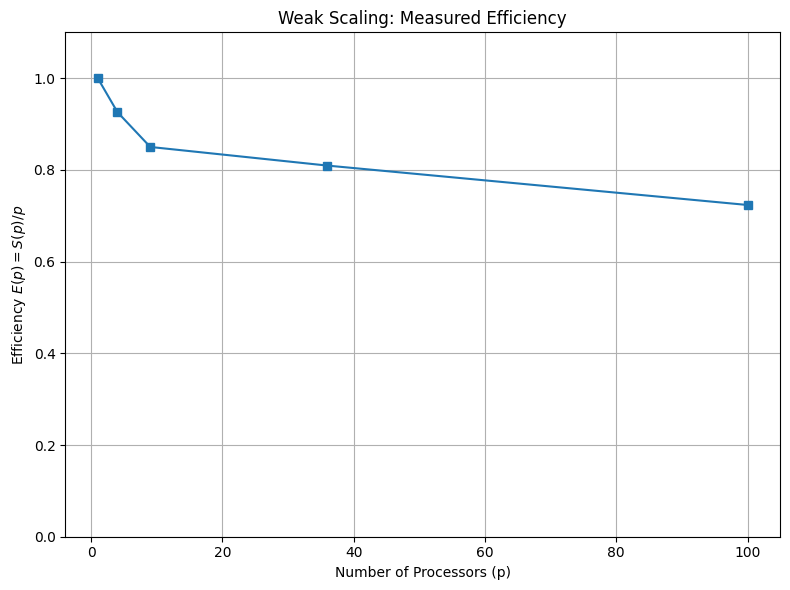

In [19]:
# Compute efficiency for both strong and weak scaling

# Strong scaling efficiency: S(p) / p
strong_efficiency = [s / p for s, p in zip(strong_speedup, strong_procs)]

# Weak scaling efficiency: S(p) / p (Gustafson style)
weak_efficiency = [s / p for s, p in zip(speedup, procs)]


# --- Strong Scaling Efficiency ---
plt.figure(figsize=(8, 6))
plt.plot(strong_procs, strong_efficiency, 'o-', color='tab:orange', label='Strong Efficiency')
plt.title('Strong Scaling: Measured Efficiency')
plt.xlabel('Number of Processors (p)')
plt.ylabel('Efficiency $E(p) = S(p) / p$')
plt.ylim(0, 1.1)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Weak Scaling Efficiency ---
plt.figure(figsize=(8, 6))
plt.plot(procs, weak_efficiency, 's-', color='tab:blue', label='Weak Efficiency')
plt.title('Weak Scaling: Measured Efficiency')
plt.xlabel('Number of Processors (p)')
plt.ylabel('Efficiency $E(p) = S(p) / p$')
plt.ylim(0, 1.1)
plt.grid(True)
plt.tight_layout()
plt.show()

